# Task 1: Retrieving and Preparing the Data

In [1]:
import datetime as dt

# Importing packages - Pandas, Numpy, Seaborn, Scipy
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, sys
import matplotlib.style as style; style.use('fivethirtyeight')
from scipy.stats import zscore, norm

np.random.seed(0)

# Modelling - LR, KNN, NB, Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Oversampling
# from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

In [2]:
# Reading the data as dataframe
file_path = "./online_retail_II.xlsx"
df = pd.read_excel(file_path)

## Attribute Information

* **`Invoice`**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* **`StockCode`**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* **`Description`** : Product (item) name. Nominal.
* **`Quantity`**: The quantities of each product (item) per transaction. Numeric.
* **`InvoiceDate`**: Invice date and time. Numeric. The day and time when a transaction was generated.
* **`Price`**: Unit price. Numeric. Product price per unit in sterling (£).
* **`Customer ID`**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
* **`Country`**: Country name. Nominal. The name of the country where a customer resides.

## Data Shape

In [3]:
# Print info of the dataframe columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [4]:
# Print out dataset's shape and the total number of missing values
print("Dataset has" , df.shape[0], "rows  and" , df.shape[1], "columns. There are ", df.isna().any().sum(), "columns with missing values")

Dataset has 525461 rows  and 8 columns. There are  2 columns with missing values


## Data Cleaning
### Dropping duplicated values

In [5]:
# Count total number of duplicated rows
df.duplicated().sum()

6865

In [6]:
# Drop all duplicated rows
df.drop_duplicates(inplace=True)
# Count total number of duplicated rows
df.duplicated().sum()

0

### Dealing with Missing values

In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107833
Country             0
dtype: int64

In specific, the **Description** column has 2928 missing values while **CustomerID** column has 107927 null values.

#### Exploratory Data Analysis
**Invoice:**
Three types of invoices:
- Start with Number
- Start with Letter A
- Start with Letter C

In [8]:
# Invoice records beginning with 'A'
df[df['Invoice'].str.contains('A', na = False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [9]:
# Invoice records beginning with 'C'
df[df["Invoice"].str.contains("C", na=False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


**StockCode & Description**
- StockCode contains 5-7 character strings mostly numbers
- Some unique StockCodes are M, B, TEST001, D

Each product's item distinguished by **StockCode** has a product description. However, with the same StockCode, the description is sometimes left blank due to error data entry. 

In [10]:
# Check null values in Description column
df[df["Description"].isnull() == True].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom


In [11]:
# Example of same stockcode but blank description
df[df['StockCode']==20683]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.00,NaN,United Kingdom
24774,491435,20683,RAIN GIRL CHILDS UMBRELLA,1,2009-12-11 10:10:00,3.25,14606.0,United Kingdom
43854,493252,20683,NaN,1,2009-12-22 13:51:00,0.00,NaN,United Kingdom


In [12]:
# Check unique description values
df['Description'].unique()

array(['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS',
       ' WHITE CHERRY LIGHTS', ..., '*Boombox Ipod Classic', 'faulty',
       'Dotcom sales'], dtype=object)

**Quantity:**

The quantity column not only displays the quantity of items purchased, but it also displays the amount of cancelled/returned items by encoding the cancelled transactions as negative. Each of these cancelled transactions is associated with the Invoice Number. However, there is only 1 instance whose invoice starts with C but the Quantity is positive (1).

In [13]:
print('Number of invoices for cancelation that also have negative quantity',
      df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] < 0)].shape[0])

Number of invoices for cancelation that also have negative quantity 10181


In [14]:
print('The number of entries with negative quantity', df[(df['Quantity'] < 0)].shape[0])

The number of entries with negative quantity 12302


In [15]:
print('Number of invoices for cancelation that also have negative quantity',
      df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] < 0)].shape[0])

Number of invoices for cancelation that also have negative quantity 10181


In [16]:
df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] < 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


In [17]:
df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] >= 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
76799,C496350,M,Manual,1,2010-02-01 08:24:00,373.57,NaN,United Kingdom


In [18]:
negative_quantities = df[df['Quantity'] < 0]
negative_quantities

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom
525235,538162,46000M,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


In [19]:
df.drop(negative_quantities.index, inplace=True)

**InvoiceDate**

In [20]:
max_invoice_date = df['InvoiceDate'].max()
min_invoice_date = df['InvoiceDate'].min()
date_fmt = '%Y-%m-%d'
print('The data ranges from {} to {}'.format(min_invoice_date.strftime(date_fmt), 
                                             max_invoice_date.strftime(date_fmt) ))

The data ranges from 2009-12-01 to 2010-12-09


**Price**

In [21]:
df['Price'].describe()

count    506294.000000
mean          3.991786
std         128.813982
min      -53594.360000
25%           1.250000
50%           2.100000
75%           4.210000
max       25111.090000
Name: Price, dtype: float64

- The maximum and minimum values could be considered to be outliers since the mean value is only **4.742955**.<br>
- The column also contains negative values.


In [22]:
# Check for rows with negative values
negative_prices = df[df['Price'] < 0]
negative_prices

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


- The **Description** column of the above rows suggests that these rows might not contain the data of real transactions. These could be made-up data which were produced to serve the purpose of dealing the bad debts.
- Based on the above hypothesis, dropping these rows could be reasonable.

In [23]:
# Dropping by using indexes
df.drop(negative_prices.index, inplace=True)

In [24]:
# Check if the rows have been dropped
negative_prices = df[df['Price'] < 0]
negative_prices

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


**Customer ID**

In [25]:
df['Customer ID'].describe()

count    400947.000000
mean      15361.454639
std        1680.669487
min       12346.000000
25%       13985.000000
50%       15311.000000
75%       16805.000000
max       18287.000000
Name: Customer ID, dtype: float64

**Country**

In [26]:
df['Country'].describe()

count             506291
unique                40
top       United Kingdom
freq              468153
Name: Country, dtype: object

In [27]:
df['Country'].value_counts()

United Kingdom          468153
EIRE                      9451
Germany                   7652
France                    5514
Netherlands               2729
Spain                     1228
Switzerland               1170
Portugal                  1058
Belgium                   1037
Sweden                     886
Channel Islands            821
Italy                      708
Australia                  630
Cyprus                     533
Austria                    524
Greece                     512
Denmark                    418
United Arab Emirates       399
Norway                     365
Finland                    347
Unspecified                306
USA                        230
Poland                     182
Malta                      170
Japan                      164
Lithuania                  154
Singapore                  117
RSA                        110
Bahrain                    106
Canada                      77
Thailand                    76
Hong Kong                   74
Israel  

In [28]:
# Check for space characters
df['Country'].str.isspace().sum()

0

- **Country** column contains names of 40 different countries without typos or duplicates or containing any space.
- **United Kingdom** appears to be the most frequent value to show up.

#### Detecting Outliers

<AxesSubplot: >

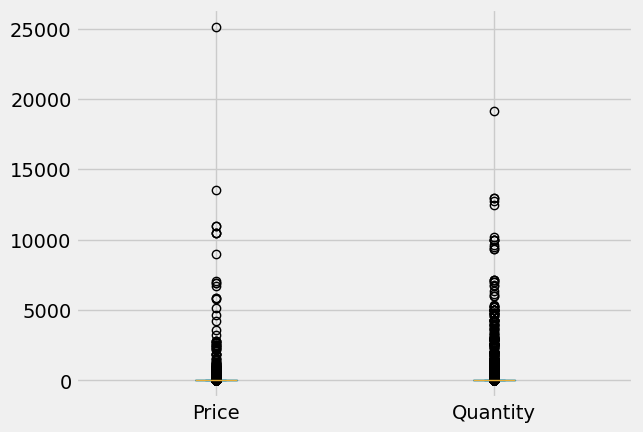

In [29]:
# Boxplot graph for Price and Quantity column
df[["Price","Quantity"]].plot(kind="box")

#### Sanity Check

Those columns having null values in **Description, Customer ID** and **Price** equals 0 are dropped because they are considered failed transactions.

In [30]:
# Drop failed transactions
idx = df[(df['Description'].isnull()) & (df['Customer ID'].isnull()) & (df['Price']==0)].index.values
df.drop(idx, inplace=True)

In [31]:
# Check the missing values
# Feature Engineering
print(df.isnull().any().sum()," are dropped")

1  are dropped


## Add new columns

In [32]:
# # Add new column: OrderCancelled
# def map_order_cancelled(row):
#     return 0 if "C" not in str(row).upper() else 1

# df["OrderCancelled"] = df["Invoice"].map(map_order_cancelled)
# removed due to heavily skewed class

0    505189
1         1
Name: OrderCancelled, dtype: int64

In [33]:
def map_international_shipping(row):
    return 0 if row == "United Kingdom" else 1
df['International Shipping']= df['Country'].map(map_international_shipping)
df['International Shipping'].value_counts()

0    467052
1     38138
Name: International Shipping, dtype: int64

In [34]:
# Add new column: TotalPrice
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [35]:
# Add date related columns
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Date']=df['InvoiceDate'].dt.date

df["Week Day"] = df["InvoiceDate"].dt.weekday
df['Day']=df['InvoiceDate'].dt.day
df['Month']=df['InvoiceDate'].dt.month
df["Quarter"] = df["InvoiceDate"].dt.quarter
df["Year"] = df["InvoiceDate"].dt.year
df['Time'] = df['InvoiceDate'].dt.time

def map_is_weekend(row):
    return 1 if row == 5 or row == 6 else 0
df['isWeekend'] = df['Week Day'].map(map_is_weekend)

# Task 2: Feature Engineering

In [36]:
df['Qdate'] = df['InvoiceDate'].dt.to_period("Q").dt.end_time
df['Qdate'].unique()
quarters = df['Qdate'].unique()

In [37]:
quarters_df_list = []

for index, quarter in enumerate(quarters):
    if (index == len(quarters) - 1):
        break;
    
    feature_df = df[df['Qdate'] == quarters[index]]
    label_df = df[df['Qdate'] == quarters[index + 1]]
    
    df_international = feature_df[feature_df["International Shipping"] == 1]
    df_international = df_international.groupby("Customer ID")["Invoice"].nunique().reset_index();
    df_international.columns = ["Customer ID", "International Shipping"]
    df_international = df_international.set_index("Customer ID");
    
    quarter_df = feature_df.groupby("Customer ID").agg({
        "TotalPrice" : ["sum", "mean", "min"],
        "Quantity": ["sum", "mean", "min", "max", "count"],
        "Price": ["mean", "min", "max"],
        "isWeekend": ["sum", "count"]
        # add more features
    })
    
    
    quarter_df = quarter_df.join(df_international)
    quarter_df = quarter_df.fillna(0)
    
    label_df = label_df.groupby("Customer ID").agg({
        "Invoice": "count"
    })

    label_df["target"] = (label_df["Invoice"] > 0).astype(int)
    label_df = label_df.drop(columns = ["Invoice"])
    
    
    final_df = quarter_df.join(label_df)
    final_df["target"] = final_df["target"].fillna(0)
    quarters_df_list.append(final_df)

final_df = pd.concat(quarters_df_list)

In [38]:
X = final_df.drop(['target'], axis = 1)
y = final_df['target']

display(X.describe().T, X.shape, y.shape);

,count,mean,std,min,25%,50%,75%,max
"(TotalPrice, sum)",6867.0,915.684483,3071.676184,0.0,230.185000,401.370000,811.655000,99125.700000
"(TotalPrice, mean)",6867.0,39.599632,201.802983,0.0,12.304094,17.742222,27.623427,10953.500000
"(TotalPrice, min)",6867.0,19.519932,178.785942,0.0,1.260000,6.600000,10.200000,10953.500000
"(Quantity, sum)",6867.0,598.987476,3592.582975,1.0,110.000000,232.000000,468.000000,220506.000000
"(Quantity, mean)",6867.0,24.984583,136.347650,1.0,5.447222,9.541667,15.263693,4866.777778
"(Quantity, min)",6867.0,9.939420,90.140854,1.0,1.000000,1.000000,3.000000,4008.000000
"(Quantity, max)",6867.0,74.169361,343.216777,1.0,20.000000,30.000000,50.000000,19152.000000
"(Quantity, count)",6867.0,40.647736,65.069929,1.0,13.000000,24.000000,48.000000,1395.000000
"(Price, mean)",6867.0,8.291558,178.337684,0.0,2.229972,2.960606,3.922511,10953.500000
"(Price, min)",6867.0,4.664130,161.059048,0.0,0.290000,0.420000,0.850000,10953.500000


(6867, 14)

(6867,)

In [39]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42);
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape);

(4806, 14)

(2061, 14)

(4806,)

(2061,)

In [40]:
def train_and_plot(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))

    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', auc.round(3))

    # ROC Curve
    model_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure(figsize = (12.8 , 6))
    plt.plot(fpr, tpr, label = 'AUC = {})'.\
             format(model_roc_auc.round(4)))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = 'lower right')
    plt.show()
    
    return model

Model accuracy for train set: 0.621
Model accuracy for test set: 0.630

              precision    recall  f1-score   support

         0.0       0.66      0.12      0.20       808
         1.0       0.63      0.96      0.76      1253

    accuracy                           0.63      2061
   macro avg       0.64      0.54      0.48      2061
weighted avg       0.64      0.63      0.54      2061


Confusion Matrix:
 [[  97  711]
 [  51 1202]]

Accuracy Score:  0.63


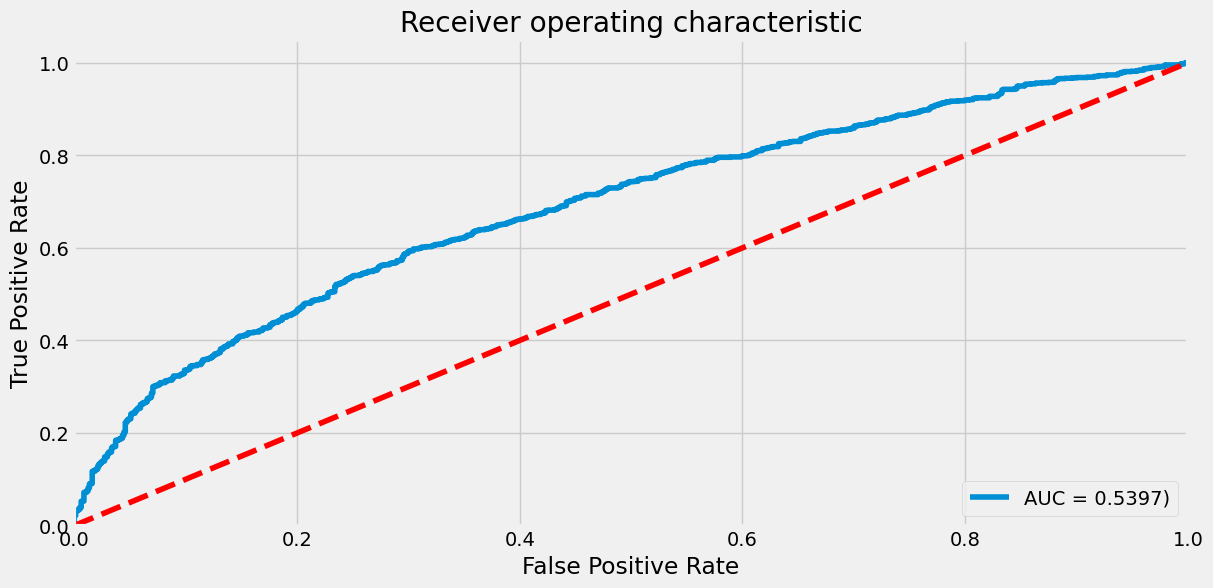

In [41]:
LR = LogisticRegression()
LR_model = train_and_plot(LR, X_train, y_train, X_test, y_test)

In [42]:
# Decision Tree

Model accuracy for train set: 0.769
Model accuracy for test set: 0.626

              precision    recall  f1-score   support

         0.0       0.53      0.42      0.47       808
         1.0       0.67      0.76      0.71      1253

    accuracy                           0.63      2061
   macro avg       0.60      0.59      0.59      2061
weighted avg       0.61      0.63      0.62      2061


Confusion Matrix:
 [[336 472]
 [299 954]]

Accuracy Score:  0.626


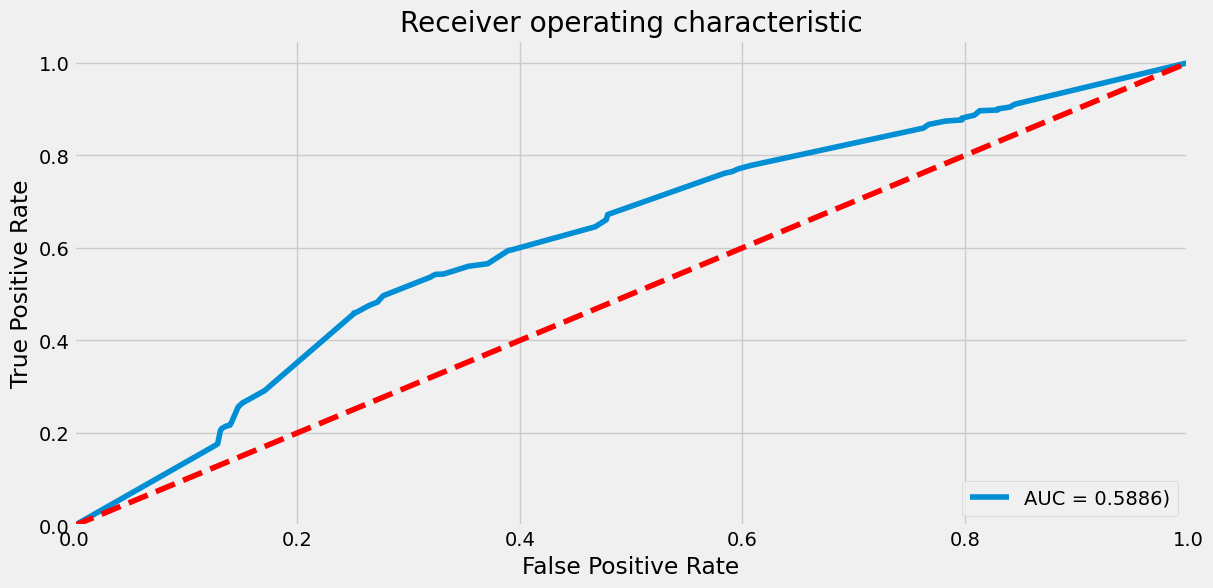

In [43]:
DTC = DecisionTreeClassifier(max_depth=11)
DTC_model = train_and_plot(DTC, X_train, y_train, X_test, y_test)

Model accuracy for train set: 0.742
Model accuracy for test set: 0.623

              precision    recall  f1-score   support

         0.0       0.52      0.45      0.48       808
         1.0       0.67      0.73      0.70      1253

    accuracy                           0.62      2061
   macro avg       0.60      0.59      0.59      2061
weighted avg       0.62      0.62      0.62      2061


Confusion Matrix:
 [[365 443]
 [333 920]]

Accuracy Score:  0.623


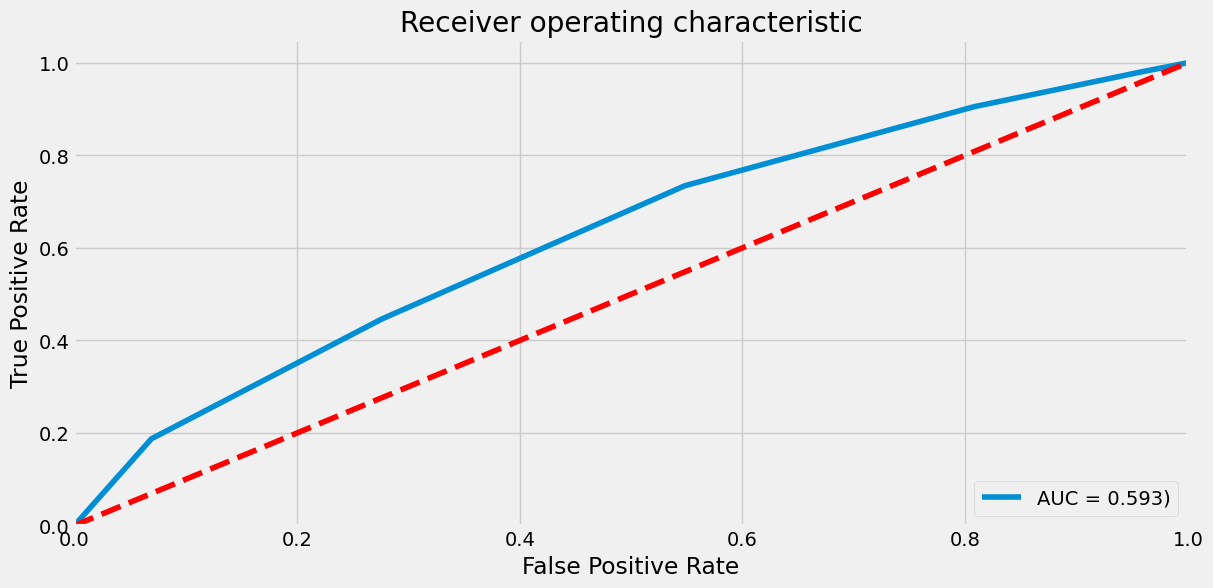

In [44]:
KNN = KNeighborsClassifier()
KNN_model = train_and_plot(KNN, X_train, y_train, X_test, y_test)